In [1]:
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import numpy as np
import pandas as pd
import string
import sqlite3

%matplotlib inline

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from PIL import Image


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#Import data
reviews = pd.read_csv('C:/Users/William/Desktop/hb reviews.csv')

In [3]:
#data info
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6844 entries, 0 to 6843
Data columns (total 21 columns):
Review ID            6844 non-null object
Published            6844 non-null object
Author               6844 non-null object
Source ID            6844 non-null object
Source               6844 non-null object
Location ID          6844 non-null object
External ID          1395 non-null object
Location             6844 non-null object
Address              6844 non-null object
City                 6844 non-null object
State                6844 non-null object
Zip                  6844 non-null int64
Rating               6844 non-null int64
Title                6844 non-null object
Review               6844 non-null object
Extra Information    0 non-null float64
URL                  6844 non-null object
Status               6844 non-null object
Notes                0 non-null float64
Tags                 0 non-null float64
Responses            435 non-null object
dtypes: float64(3), 

In [4]:
#Dropping some un-needed columns
reviews = reviews.drop(['Notes', 'Tags', 'Extra Information'], axis=1)


In [5]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6844 entries, 0 to 6843
Data columns (total 18 columns):
Review ID      6844 non-null object
Published      6844 non-null object
Author         6844 non-null object
Source ID      6844 non-null object
Source         6844 non-null object
Location ID    6844 non-null object
External ID    1395 non-null object
Location       6844 non-null object
Address        6844 non-null object
City           6844 non-null object
State          6844 non-null object
Zip            6844 non-null int64
Rating         6844 non-null int64
Title          6844 non-null object
Review         6844 non-null object
URL            6844 non-null object
Status         6844 non-null object
Responses      435 non-null object
dtypes: int64(2), object(16)
memory usage: 962.5+ KB


In [6]:
reviews.head()

,Review ID,Published,Author,Source ID,Source,Location ID,External ID,Location,Address,City,State,Zip,Rating,Title,Review,URL,Status,Responses
0,5a7a88104ee9ca00046f91a6,2/7/2018,Luis Pineda,8c88a35d0000003000000000,Facebook,5a724f5c6fbc8917b5317e00,NaN,"Hattie B's Hot Chicken - Birmingham, AL",2808 7th Ave S 29 Seven Apartments 101,Birmingham,Alabama,35233,5,������� 1st time...,������� 1st time trying the B'ham location an...,https://www.facebook.com/Hattiebham/reviews,--,NaN
1,5a7b4dc1621b990004b348a2,2/7/2018,Rodger Brummett,8c88a35d0000000800000000,TripAdvisor,5a724da73f8a4515c330e5b4,NaN,"Hattie B's Hot Chicken - Midtown Nashville, TN",112 19th Ave S,Nashville,Tennessee,37203,5,Great food,Really enjoyed the hot chicken. Would recom...,http://www.tripadvisor.com/Restaurant_Review-g...,--,NaN
2,5a7b4dc08cde5000045c28de,2/7/2018,Stefanie Howerton,8c88a35d0000003000000000,Facebook,5a724da73f8a4515c330e5b4,NaN,"Hattie B's Hot Chicken - Midtown Nashville, TN",112 19th Ave S,Nashville,Tennessee,37203,5,�� My only...,"��\nMy only regret was not going for ""Damn Ho...",https://www.facebook.com/HattieBsMidtownNashvi...,--,NaN
3,5a7a88104ee9ca00046f919c,2/7/2018,Donna Edwards,8c88a35d0000000200000000,Yelp,5a724f46b4d8d61aa350f2ca,Melrose,Hattie B's Hot Chicken Melrose,2222 8th Ave South,Nashville,Tennessee,37204,4,"""Damn hot"" chicken...","""Damn hot"" chicken wings was super hot! Could...",https://www.yelp.com/biz/hattie-bs-hot-chicken...,--,NaN
4,5a7b4dc0c6a65e0004c1e6b8,2/7/2018,Andrew Lundborg,8c88a35d0000000200000000,Yelp,5a7371e8e48ea828c376c026,NaN,Hattie B's Hot Chicken West,5209 Charlotte Pike,Nashville,Tennessee,37209,4,"""Damn hot"" chicken...","""Damn hot"" chicken wings was super hot! Could...",https://www.yelp.com/biz/hattie-bs-hot-chicken...,--,NaN


In [7]:
#remove all reviwes except for Broadway
negreviews = reviews[reviews['Rating'] < 4]
negreviews = negreviews[~negreviews.State.str.contains("Alabama")]
negreviews = negreviews[~negreviews.Address.str.contains("2222 8th Ave South")]
negreviewsBW = negreviews[~negreviews.Address.str.contains("5209 Charlotte Pike")]

In [8]:
#Turn reviews into text string to parse
negreviewsBW.to_string(columns=['Review'])

'                                                 Review\n13     **** Save yourself the time and either get it...\n16     1) Not very tasty compared to Prince\'s. 2) Im...\n19     1. Hattie B\'s will never be a substitute for ...\n31     I know Hattie B\'s is a Nashville tradition, b...\n33     3.5 Stars   I heard so much about the famous ...\n49     A disclaimer up front: I am not a fan of hot ...\n59     3 tries to get in. Otherwise too busy to wait...\n60     We waited anxiously for 25 minutes in 90+ tem...\n61     A one hour wait left me a bit disappointed.  ...\n62     They don\'t know how to handle busy, which is ...\n100    We were told that while we were visiting Nash...\n119    We visited this place since it\'s a " must do ...\n195    After waiting in a long line for take out. I ...\n214    Alright everyone, just so you know, Hattie\'s ...\n319    Amazing food. But......My takeout was suppose...\n417    At 2 PM on a weekday, there was no parking an...\n421    Ate here last nit

In [9]:
#Columns setup
columns = ['Rating', 'Review']
#create a df with rating and review columns called messages
messages = negreviewsBW[columns]
#Create a Summary array of every message as an item in the array 
Summary = messages['Review']
messages.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 360 entries, 13 to 6687
Data columns (total 2 columns):
Rating    360 non-null int64
Review    360 non-null object
dtypes: int64(1), object(1)
memory usage: 8.4+ KB


In [10]:
#Import slanguage word stemmer as stemmer
stemmer = PorterStemmer()
#import nltk

from nltk.corpus import stopwords

#Stem the dataset words to normalize the data somewhat
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed
#Tokenizes all the stemmed words and returns them joined by a space
def tokenize(text):
    tokens = nltk.word_tokenize(text)   # Resource 'tokenizers/punkt/english.pickle' not found
    stems = stem_tokens(tokens, stemmer)
    return ' '.join(stems)

# replace each punctuation with a space
intab = string.punctuation
outtab = "                                "
trantab = str.maketrans(intab, outtab)

#--- Training set

corpus = []
#Create an array called Corpus that has our text stemmed and tokenized for analysis
for text in Summary:
    text = str(text)
    text = text.lower()
    text = text.translate(trantab)
    text=tokenize(text)
    corpus.append(text)

    
count_vect = CountVectorizer()
#Train on the review data
X_train_counts = count_vect.fit_transform(corpus)        

#Transform the counts from training data to fit the model
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# print tokenized text and text before tokenizing
from pandas import *
df = DataFrame({'Before': Summary, 'After': corpus})
print(df.head(20))


prediction = dict()
    

                                                 After  \
13   save yourself the time and either get it to go...   
16   1 not veri tasti compar to princ s 2 imposs to...   
19   1 hatti b s will never be a substitut for prin...   
31   i know hatti b s is a nashvil tradit but we wa...   
33   3 5 star i heard so much about the famou nashv...   
49   a disclaim up front i am not a fan of hot food...   
59   3 tri to get in otherwis too busi to wait gues...   
60   we wait anxious for 25 minut in 90 temperatur ...   
61   a one hour wait left me a bit disappoint i ord...   
62   they don t know how to handl busi which is unf...   
100  we were told that while we were visit nashvil ...   
119  we visit thi place sinc it s a must do while i...   
195  after wait in a long line for take out i get t...   
214  alright everyon just so you know hatti s is on...   
319  amaz food but my takeout wa suppos to be readi...   
417  at 2 pm on a weekday there wa no park and ther...   
421  ate here 

In [11]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 360 entries, 13 to 6687
Data columns (total 2 columns):
After     360 non-null object
Before    360 non-null object
dtypes: object(2)
memory usage: 8.4+ KB


ERROR:root:Line magic function `%paste` not found.


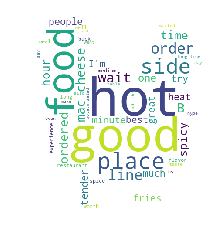

In [13]:
#create a wordcloud of the positive sentiment

%paste
from os import path
from wordcloud import WordCloud
from nltk.corpus import stopwords

d = path.dirname('C:/Users/William/Desktop')

#input stop words to remove from wordcloud
stopwords = stopwords.words('english')
#input stop words specific to the business case
newstops = [' B ','I','way','ok','eat','chicken', 'Hattie B', 'Nashville', 'get', 'go', 'Hattie', 'B', ' B', 'really', 'fried', 'got', 'would', 'better', 'like']
#Add those custom stopwords to the stopwords list
stopwords.extend(newstops)

#open the jpg as the base for the wordcloud
preds_mask = np.array(Image.open(path.join(d, 'C:/Users/William/Desktop/chicken.jpg')))

#Use the WordCloud function and inputs to create the wordcloud paramters
cloud = WordCloud(background_color="white", max_words=50, mask = preds_mask, stopwords = stopwords)

#Display the wordcloud
positive_cloud = cloud.generate(df['Before'].str.cat(sep='\n'))
plt.figure()
plt.imshow(positive_cloud)
plt.axis("off")
plt.show()
#Save the wordcloud to file
positive_cloud.to_file(path.join(d, 'C:/Users/William/Desktop/BWnegchicken50.png'))

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from nltk.corpus import stopwords

stopwordsk = stopwords.words('english')
newstopsk = ['great','good','food','hot','nashville','hattie','I','way','ok','eat','chicken', 'Hattie B', 'Nashville', 'get', 'go', 'Hattie', 'B', ' B', 'really', 'fried', 'got', 'would', 'better', 'like']
stopwordsk.extend(newstopsk)


vectorizer = TfidfVectorizer(stop_words=stopwordsk)
X = vectorizer.fit_transform(df['Before'])

#K means clustering to see what words for negative reviewed tend to be together
#This can give some more context for why people leave certain reviews
true_k = 5
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=20, n_init=1)
model.fit(X)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :5]:
        print(' %s' % terms[ind]),
    print
 
 
print("\n")
print("Prediction")

Top terms per cluster:
Cluster 0:
 flavor
 restaurant
 hype
 worth
 kfc
Cluster 1:
 average
 place
 spicy
 long
 sure
Cluster 2:
 line
 cheese
 minutes
 mac
 ordered
Cluster 3:
 wait
 line
 worth
 hour
 long
Cluster 4:
 prince
 pepperfire
 clean
 best
 fake


Prediction
